## Setup & dataset

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
import random

# ----- Paths -----
DATA_ROOT = Path("/kaggle/input/ham1000-segmentation-and-classification")
IMAGES_DIR = DATA_ROOT / "images"
MASKS_DIR = DATA_ROOT / "masks"

MODEL_ROOT = Path("/kaggle/input/transunet-model-outputs/ham_transunet_outputs")
BEST_MODEL_PATH = MODEL_ROOT / "best_transunet_aeo.pth"

IMG_SIZE = 256
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

# ----- Dataset used only for visualization/inference -----
class HAMSegmentationDataset(Dataset):
    def __init__(self, image_ids, img_dir, mask_dir=None, transforms=None):
        self.image_ids = image_ids
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transforms = transforms

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_path = self.img_dir / f"{img_id}.jpg"
        image = np.array(Image.open(img_path).convert("RGB"))

        mask = None
        if self.mask_dir is not None:
            mask_path = self.mask_dir / f"{img_id}_segmentation.png"
            mask = np.array(Image.open(mask_path).convert("L"))
            mask = (mask > 0).astype("float32")

        if self.transforms:
            if mask is not None:
                augmented = self.transforms(image=image, mask=mask)
                image = augmented["image"]
                mask = augmented["mask"].unsqueeze(0)
            else:
                augmented = self.transforms(image=image)
                image = augmented["image"]

        if mask is None:
            return image, img_id
        return image, mask, img_id

# simple val transforms
val_transforms = A.Compose(
    [
        A.Resize(IMG_SIZE, IMG_SIZE),
        A.Normalize(mean=(0.485, 0.456, 0.406),
                    std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

# build a list of image IDs
all_img_files = sorted([p for p in IMAGES_DIR.iterdir() if p.suffix == ".jpg"])
all_ids = [p.stem for p in all_img_files]

val_dataset = HAMSegmentationDataset(all_ids, IMAGES_DIR, MASKS_DIR, val_transforms)
print("Total images available:", len(val_dataset))

Device: cuda
Total images available: 10015


## Re-create model architecture and load weights

In [2]:
# ----- TransUNet model definition -----
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.block(x)

class UpBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_ch, out_ch, kernel_size=2, stride=2)
        self.conv = ConvBlock(in_ch, out_ch)

    def forward(self, x, skip):
        x = self.up(x)
        if x.size(-1) != skip.size(-1) or x.size(-2) != skip.size(-2):
            diff_y = skip.size(-2) - x.size(-2)
            diff_x = skip.size(-1) - x.size(-1)
            x = F.pad(x, [diff_x // 2, diff_x - diff_x // 2,
                          diff_y // 2, diff_y - diff_y // 2])
        x = torch.cat([skip, x], dim=1)
        return self.conv(x)

class TransUNetAEO(nn.Module):
    def __init__(self, img_size=256, in_ch=3, num_classes=1,
                 base_ch=64, num_heads=4, transformer_layers=4, dropout=0.1):
        super().__init__()
        self.enc1 = ConvBlock(in_ch, base_ch)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = ConvBlock(base_ch, base_ch*2)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = ConvBlock(base_ch*2, base_ch*4)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = ConvBlock(base_ch*4, base_ch*8)
        self.pool4 = nn.MaxPool2d(2)

        bottleneck_ch = base_ch * 16
        self.bottleneck_conv = ConvBlock(base_ch*8, bottleneck_ch)

        H = img_size // 16
        W = img_size // 16
        d_model = bottleneck_ch

        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=num_heads,
            dim_feedforward=d_model*4, dropout=dropout,
            batch_first=False
        )
        self.transformer = nn.TransformerEncoder(enc_layer, transformer_layers)

        self.up4 = UpBlock(bottleneck_ch, base_ch*8)
        self.up3 = UpBlock(base_ch*8, base_ch*4)
        self.up2 = UpBlock(base_ch*4, base_ch*2)
        self.up1 = UpBlock(base_ch*2, base_ch)
        self.final_conv = nn.Conv2d(base_ch, num_classes, 1)

    def forward(self, x):
        e1 = self.enc1(x); p1 = self.pool1(e1)
        e2 = self.enc2(p1); p2 = self.pool2(e2)
        e3 = self.enc3(p2); p3 = self.pool3(e3)
        e4 = self.enc4(p3); p4 = self.pool4(e4)

        b = self.bottleneck_conv(p4)
        B, C, H, W = b.shape
        seq = b.flatten(2).permute(2, 0, 1)   # (S,B,C)
        seq = self.transformer(seq)
        b = seq.permute(1, 2, 0).view(B, C, H, W)

        d4 = self.up4(b, e4)
        d3 = self.up3(d4, e3)
        d2 = self.up2(d3, e2)
        d1 = self.up1(d2, e1)

        return self.final_conv(d1)

# ----- load weights -----
model = TransUNetAEO(img_size=IMG_SIZE).to(DEVICE)
model.load_state_dict(torch.load(BEST_MODEL_PATH, map_location=DEVICE))
model.eval()
print("Loaded best model from:", BEST_MODEL_PATH)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Loaded best model from: /kaggle/input/transunet-model-outputs/ham_transunet_outputs/best_transunet_aeo.pth


## Visualize predictions vs ground truth

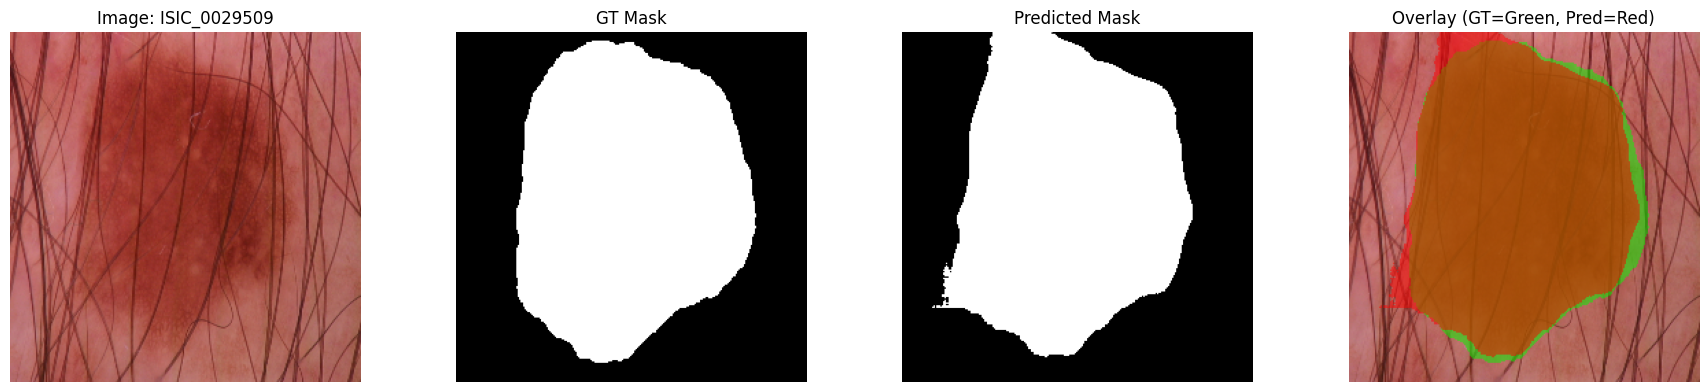

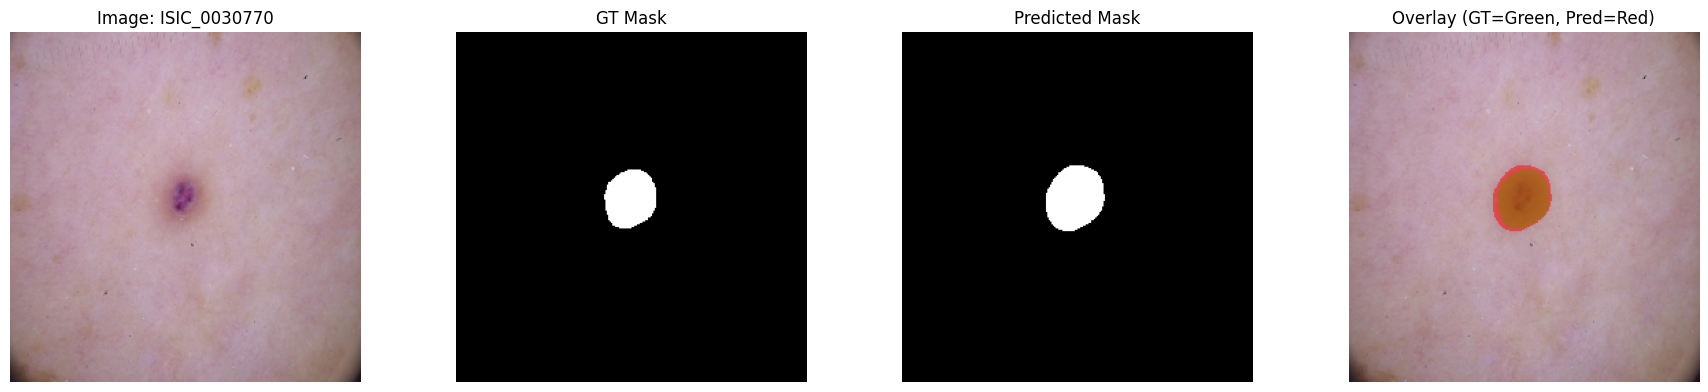

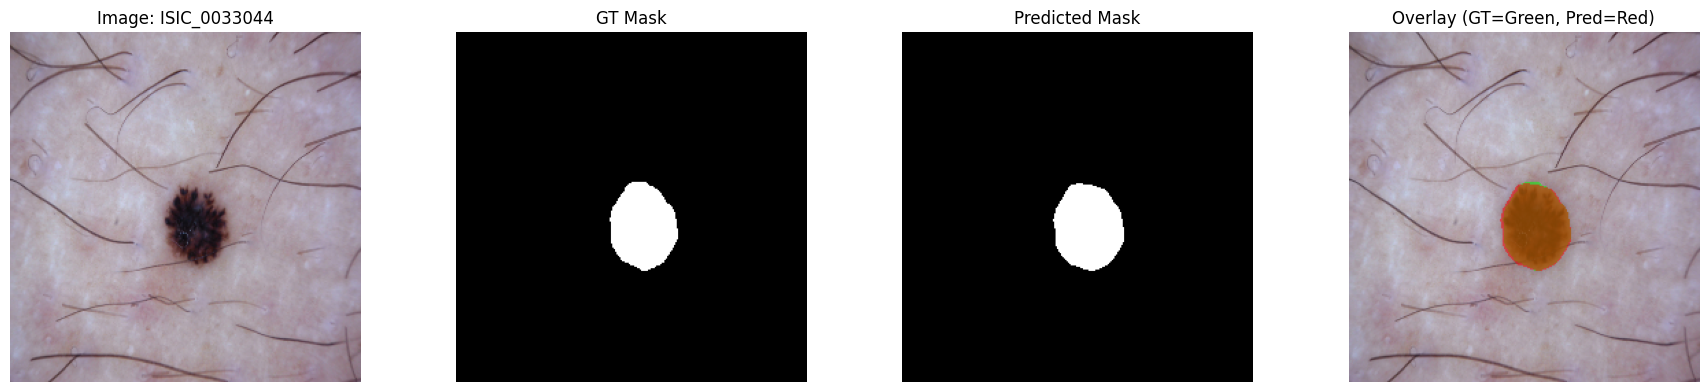

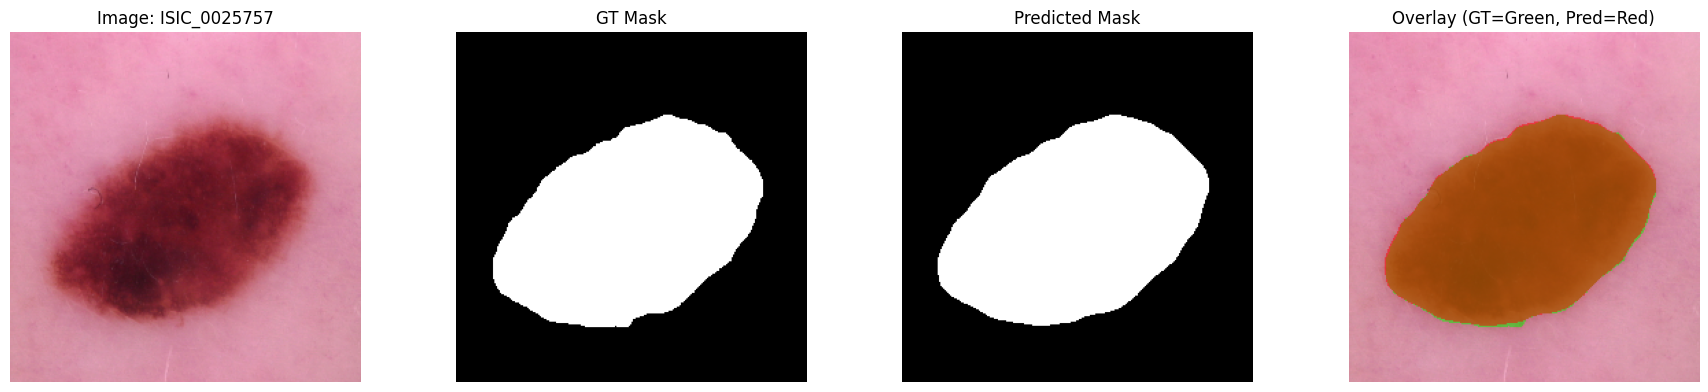

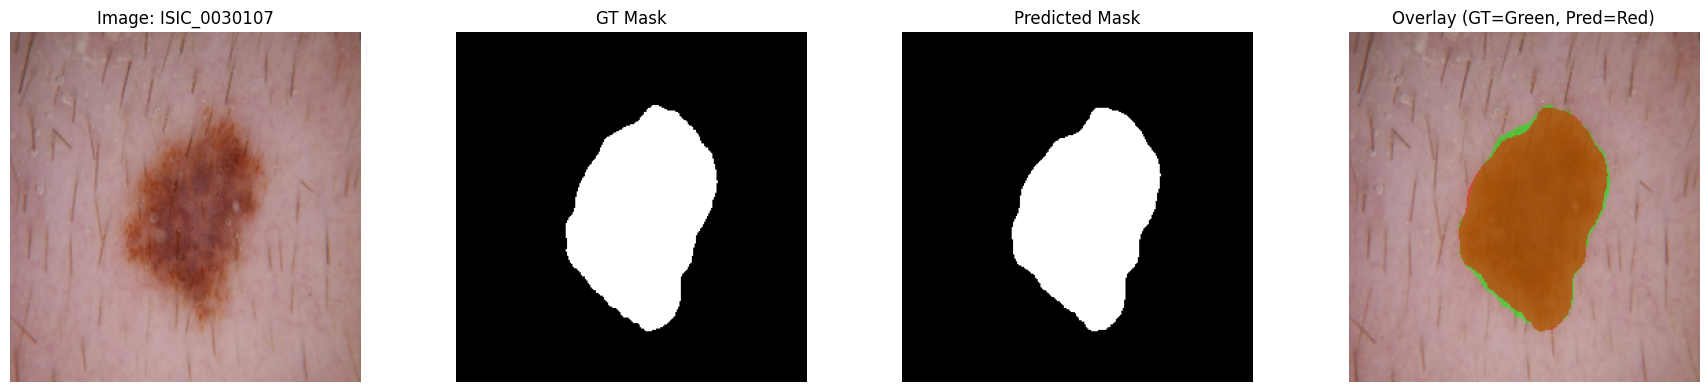

In [3]:
IMAGENET_MEAN = np.array([0.485, 0.456, 0.406])
IMAGENET_STD  = np.array([0.229, 0.224, 0.225])

def tensor_to_image(t):
    img = t.cpu().numpy().transpose(1, 2, 0)
    img = img * IMAGENET_STD + IMAGENET_MEAN
    return np.clip(img, 0, 1)

def show_example(idx):
    img, mask, img_id = val_dataset[idx]
    img_in = img.unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        logits = model(img_in)
        probs = torch.sigmoid(logits)[0,0].cpu().numpy()
        pred = (probs > 0.5).astype(np.float32)

    gt = mask[0].cpu().numpy()
    vis_img = tensor_to_image(img)

    overlay = vis_img.copy()
    alpha = 0.5
    # GT green
    overlay[gt > 0.5] = alpha*np.array([0,1,0]) + (1-alpha)*overlay[gt>0.5]
    # Pred red
    overlay[pred > 0.5] = alpha*np.array([1,0,0]) + (1-alpha)*overlay[pred>0.5]

    fig, axs = plt.subplots(1,4, figsize=(18,4))
    axs[0].imshow(vis_img); axs[0].set_title(f"Image: {img_id}"); axs[0].axis("off")
    axs[1].imshow(gt, cmap="gray"); axs[1].set_title("GT Mask"); axs[1].axis("off")
    axs[2].imshow(pred, cmap="gray"); axs[2].set_title("Predicted Mask"); axs[2].axis("off")
    axs[3].imshow(overlay); axs[3].set_title("Overlay (GT=Green, Pred=Red)"); axs[3].axis("off")
    plt.tight_layout()
    plt.show()

# show 5 random examples
for _ in range(5):
    i = random.randrange(0, len(val_dataset))
    show_example(i)